#### Feature Engineering - Predicción del Rendimiento en Corredores
Objetivo
Crear features temporales y métricas de rendimiento a partir de los datos de actividades de Strava para predecir el rendimiento futuro de corredores mediante técnicas de Machine Learning.

Proceso de Feature Engineering
1. Carga y Preparación de Datos
- Lectura del dataset procesado strava_final.csv
-- Conversión de fechas a formato datetime
Verificación de la estructura de datos
2. Creación de Features Temporales
- Ventana de 7 días:
- weekly_km: Kilómetros acumulados semanales
- sessions_last_7d: Número de sesiones en la última semana
- elevation_weekly: Desnivel acumulado semanal
- Ventana de 28 días (4 semanas):
- mean_pace_4w: Ritmo promedio de las últimas 4 semanas
- std_pace_4w: Desviación estándar del ritmo (consistencia)
- mean_hr_4w: Frecuencia cardíaca promedio
3. Métricas de Rendimiento
- Best paces: Mejores tiempos en distancias 5K y 10K
- Efficiency: Ratio velocidad promedio (km/h) por usuario
- Days since last race: Días desde la última actividad
4. Análisis Exploratorio de Datos (EDA)
- Visualización de distribuciones (histogramas + boxplots)
- Detección de outliers por variable
- Matriz de correlaciones entre features
- Análisis de variabilidad entre usuarios
5. Limpieza y Tratamiento de Outliers
- Eliminación de valores extremos identificados:
- mean_pace_4w > 8.0 min/km
- sessions_last_7d > 7 sesiones
- best_5k_pace > 7.0 min/km
6. Dataset Final
- Resumen por usuario: Estado más reciente de cada corredor
- Variables clave para modelado: Features temporales + métricas de rendimiento
- Dataset listo para algoritmos de Machine Learning
7. Resultados Esperados
Un dataset enriquecido con features que capturen:
- Carga de entrenamiento reciente
- Consistencia en el rendimiento
- Capacidad máxima del corredor
- Patrones temporales de actividad
Este dataset servirá como input para modelos predictivos que estimarán el rendimiento futuro de corredores basándose en su historial de entrenamientos.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


In [2]:
df = pd.read_csv(r"C:\Users\eduar\OneDrive\Escritorio\Master_DataScience_AI\TFM. “Predicción del rendimiento en corredores mediante técnicas de Machine Learning un enfoque aplicado al sector deportivo”\processed\strava_final.csv")

In [3]:
df.head()

,activity_id,activity_date,activity_type,distance_km,elapsed_time_hms,pace_formatted,elevation_gain,avg_cadence,avg_heart_rate,max_heart_rate,calories,user,Edad,Sexo,Peso,Altura,Nivel_experiencia,Objetivo,Dias_entrenamiento
0,12286569161,2024-08-31 07:29:23,Run,4.00,00:20:27,5.07,2.4,NaN,NaN,NaN,NaN,Diego Llorente,26,Masculino,65,170,Avanzado,Salud / Ocio,3
1,12312426596,2024-09-03 06:32:46,Run,7.00,00:39:19,5.37,7.0,NaN,NaN,NaN,NaN,Diego Llorente,26,Masculino,65,170,Avanzado,Salud / Ocio,3
2,12327869051,2024-09-04 20:42:36,Run,8.00,00:45:00,5.38,64.7,NaN,NaN,NaN,NaN,Diego Llorente,26,Masculino,65,170,Avanzado,Salud / Ocio,3
3,12377627761,2024-09-10 18:36:55,Run,5.01,00:24:54,4.58,35.8,NaN,NaN,NaN,NaN,Diego Llorente,26,Masculino,65,170,Avanzado,Salud / Ocio,3
4,12377934099,2024-09-10 19:06:02,Run,6.01,00:36:29,6.04,55.9,NaN,NaN,NaN,NaN,Diego Llorente,26,Masculino,65,170,Avanzado,Salud / Ocio,3


In [4]:
# convertir la columna 'activity_date' a tipo datetime
df['activity_date'] = pd.to_datetime(df['activity_date'], errors='coerce')

In [5]:
df.head()

,activity_id,activity_date,activity_type,distance_km,elapsed_time_hms,pace_formatted,elevation_gain,avg_cadence,avg_heart_rate,max_heart_rate,calories,user,Edad,Sexo,Peso,Altura,Nivel_experiencia,Objetivo,Dias_entrenamiento
0,12286569161,2024-08-31 07:29:23,Run,4.00,00:20:27,5.07,2.4,NaN,NaN,NaN,NaN,Diego Llorente,26,Masculino,65,170,Avanzado,Salud / Ocio,3
1,12312426596,2024-09-03 06:32:46,Run,7.00,00:39:19,5.37,7.0,NaN,NaN,NaN,NaN,Diego Llorente,26,Masculino,65,170,Avanzado,Salud / Ocio,3
2,12327869051,2024-09-04 20:42:36,Run,8.00,00:45:00,5.38,64.7,NaN,NaN,NaN,NaN,Diego Llorente,26,Masculino,65,170,Avanzado,Salud / Ocio,3
3,12377627761,2024-09-10 18:36:55,Run,5.01,00:24:54,4.58,35.8,NaN,NaN,NaN,NaN,Diego Llorente,26,Masculino,65,170,Avanzado,Salud / Ocio,3
4,12377934099,2024-09-10 19:06:02,Run,6.01,00:36:29,6.04,55.9,NaN,NaN,NaN,NaN,Diego Llorente,26,Masculino,65,170,Avanzado,Salud / Ocio,3


In [6]:
def compute_temporal_features(df):
    df['activity_date'] = pd.to_datetime(df['activity_date'], errors='coerce')
    df = df.sort_values(['user', 'activity_date'])
    df = df.set_index('activity_date')

    frames = []
    for user, g in df.groupby('user'):
        g = g.sort_index()
        out = pd.DataFrame(index=g.index)
        # Ventana de 7 días
        out['weekly_km'] = g['distance_km'].rolling('7d').sum()
        out['sessions_last_7d'] = g['distance_km'].rolling('7d').count()
        out['elevation_weekly'] = g['elevation_gain'].rolling('7d').sum()
        # Ventana de 28 días (4 semanas)
        out['mean_pace_4w'] = g['pace_formatted'].rolling('28d').mean()
        out['std_pace_4w'] = g['pace_formatted'].rolling('28d').std()
        out['mean_hr_4w'] = g['avg_heart_rate'].rolling('28d').mean()
        # Añade identificador de usuario y actividad
        out['user'] = user
        out['activity_id'] = g['activity_id'].values
        # Elimina columnas duplicadas antes de unir
        g_no_dupes = g.drop(columns=['user', 'activity_id'])
        out = out.join(g_no_dupes)
        frames.append(out.reset_index())

    df_features = pd.concat(frames, ignore_index=True)
    return df_features


df_features = compute_temporal_features(df)

In [7]:
df_features.tail(10)

,activity_date,weekly_km,sessions_last_7d,elevation_weekly,mean_pace_4w,std_pace_4w,mean_hr_4w,user,activity_id,activity_type,...,avg_heart_rate,max_heart_rate,calories,Edad,Sexo,Peso,Altura,Nivel_experiencia,Objetivo,Dias_entrenamiento
663,2025-07-27 11:00:34,3.61,1.0,5.1,6.090000,NaN,NaN,marta,15251882106,Carrera,...,NaN,NaN,266.0,24,Femenino,54,165,Intermedio,10 km,4 deporte y correr no constante
664,2025-09-01 10:41:16,5.01,1.0,11.1,5.590000,NaN,NaN,marta,15657740727,Carrera,...,NaN,NaN,370.0,24,Femenino,54,165,Intermedio,10 km,4 deporte y correr no constante
665,2025-09-03 06:53:33,11.83,2.0,102.7,7.940000,3.323402,NaN,marta,15679935707,Carrera,...,NaN,NaN,505.0,24,Femenino,54,165,Intermedio,10 km,4 deporte y correr no constante
666,2025-09-05 18:29:34,16.98,3.0,226.8,7.456667,2.494661,NaN,marta,15709030639,Carrera,...,NaN,NaN,414.0,24,Femenino,54,165,Intermedio,10 km,4 deporte y correr no constante
667,2025-09-07 08:26:23,26.98,4.0,244.9,7.195000,2.103037,NaN,marta,15726015636,Carrera,...,NaN,NaN,738.0,24,Femenino,54,165,Intermedio,10 km,4 deporte y correr no constante
668,2025-09-08 18:10:34,27.34,4.0,293.5,7.556000,1.992155,NaN,marta,15743763552,Carrera,...,NaN,NaN,409.0,24,Femenino,54,165,Intermedio,10 km,4 deporte y correr no constante
669,2025-09-10 18:33:37,29.47,4.0,237.0,7.491667,1.788792,NaN,marta,15767953262,Carrera,...,NaN,NaN,663.0,24,Femenino,54,165,Intermedio,10 km,4 deporte y correr no constante
670,2025-09-13 09:00:51,29.48,4.0,123.6,7.191429,1.815897,NaN,marta,15794401738,Carrera,...,NaN,NaN,380.0,24,Femenino,54,165,Intermedio,10 km,4 deporte y correr no constante
671,2025-09-14 07:01:01,39.56,5.0,182.4,6.950000,1.814584,NaN,marta,15804793496,Carrera,...,NaN,NaN,748.0,24,Femenino,54,165,Intermedio,10 km,4 deporte y correr no constante
672,2025-09-15 19:13:51,29.41,4.0,128.4,6.783333,1.769499,NaN,marta,15823153322,Carrera,...,NaN,NaN,387.0,24,Femenino,54,165,Intermedio,10 km,4 deporte y correr no constante


In [8]:
def hms_to_seconds(hms_str):
    """Convierte una cadena HH:MM:SS a segundos."""
    if pd.isnull(hms_str):
        return 0
    parts = hms_str.split(':')
    if len(parts) == 3:
        h, m, s = map(int, parts)
        return h * 3600 + m * 60 + s
    return 0

def compute_best_paces_efficiency(df):
    # Asegúrate de que activity_date sea datetime y esté ordenado
    df['activity_date'] = pd.to_datetime(df['activity_date'], errors='coerce')
    df = df.sort_values(['user', 'activity_date'])

    # Convertir elapsed_time_hms a segundos
    df['elapsed_time_seconds'] = df['elapsed_time_hms'].apply(hms_to_seconds)

    results = []
    for user, g in df.groupby('user'):
        g = g.sort_values('activity_date')
        # Best paces (5k y 10k, tolerancia)
        best_5k = g[(g['distance_km'] >= 4.8) & (g['distance_km'] <= 5.2)]['pace_formatted'].min()
        best_10k = g[(g['distance_km'] >= 9.5) & (g['distance_km'] <= 10.5)]['pace_formatted'].min()
        # Efficiency: distancia total / tiempo total (km/h)
        total_distance = g['distance_km'].sum()
        total_time_h = g['elapsed_time_seconds'].sum() / 3600
        efficiency = total_distance / total_time_h if total_time_h > 0 else np.nan
        # Días desde última carrera
        g['days_since_last_race'] = g['activity_date'].diff().dt.days
        # Añadir resultados a cada fila
        g['best_10k_pace'] = best_10k
        g['best_5k_pace'] = best_5k
        g['efficiency_kmh'] = efficiency
        results.append(g)

    df_out = pd.concat(results, ignore_index=True)
    return df_out


df_features = compute_best_paces_efficiency(df_features)

In [9]:
df_features.tail()

,activity_date,weekly_km,sessions_last_7d,elevation_weekly,mean_pace_4w,std_pace_4w,mean_hr_4w,user,activity_id,activity_type,...,Peso,Altura,Nivel_experiencia,Objetivo,Dias_entrenamiento,elapsed_time_seconds,days_since_last_race,best_10k_pace,best_5k_pace,efficiency_kmh
668,2025-09-08 18:10:34,27.34,4.0,293.5,7.556000,1.992155,NaN,marta,15743763552,Carrera,...,54,165,Intermedio,10 km,4 deporte y correr no constante,2898,1.0,5.26,5.39,9.021443
669,2025-09-10 18:33:37,29.47,4.0,237.0,7.491667,1.788792,NaN,marta,15767953262,Carrera,...,54,165,Intermedio,10 km,4 deporte y correr no constante,3909,2.0,5.26,5.39,9.021443
670,2025-09-13 09:00:51,29.48,4.0,123.6,7.191429,1.815897,NaN,marta,15794401738,Carrera,...,54,165,Intermedio,10 km,4 deporte y correr no constante,1747,2.0,5.26,5.39,9.021443
671,2025-09-14 07:01:01,39.56,5.0,182.4,6.950000,1.814584,NaN,marta,15804793496,Carrera,...,54,165,Intermedio,10 km,4 deporte y correr no constante,3288,0.0,5.26,5.39,9.021443
672,2025-09-15 19:13:51,29.41,4.0,128.4,6.783333,1.769499,NaN,marta,15823153322,Carrera,...,54,165,Intermedio,10 km,4 deporte y correr no constante,1803,1.0,5.26,5.39,9.021443


In [10]:
print("Rows:", df_features.shape[0])
print("Users:", df_features['user'].nunique())
print(df_features[['weekly_km','sessions_last_7d','mean_pace_4w']].describe())
print("NaNs per col:\n", df_features.isna().sum().sort_values())


Rows: 673
Users: 10
        weekly_km  sessions_last_7d  mean_pace_4w
count  673.000000        673.000000    673.000000
mean    18.811991          2.803863      5.844237
std     10.811058          1.417424      0.949537
min      1.170000          1.000000      4.410000
25%     10.210000          2.000000      5.198571
50%     17.330000          3.000000      5.559000
75%     26.000000          4.000000      6.245833
max     55.900000          8.000000     12.050000
NaNs per col:
 activity_date             0
best_10k_pace             0
elapsed_time_seconds      0
Dias_entrenamiento        0
Objetivo                  0
Nivel_experiencia         0
Altura                    0
Peso                      0
Sexo                      0
Edad                      0
best_5k_pace              0
pace_formatted            0
efficiency_kmh            0
distance_km               0
weekly_km                 0
activity_type             0
activity_id               0
user                      0
elapsed_tim

In [11]:
# Selecciona la última fila (actividad más reciente) de cada usuario
user_summary = df_features.sort_values(['user', 'activity_date']).groupby('user').tail(1)

# Opcional: selecciona solo las columnas relevantes para el modelo
cols_modelo = [
    'user', 'activity_date', 'weekly_km', 'sessions_last_7d', 'elevation_weekly',
    'mean_pace_4w', 'std_pace_4w', 'mean_hr_4w', 'best_5k_pace', 'best_10k_pace',
    'efficiency_kmh'
]
user_summary = user_summary[cols_modelo]

# Mostrar el resumen
print(user_summary)

                      user       activity_date  weekly_km  sessions_last_7d  \
79          Diego Llorente 2025-09-09 17:24:25      20.94               3.0   
178        Eduardo Sánchez 2025-09-03 18:13:10       4.03               1.0   
276  Hugo Magallón Causapé 2025-09-10 16:22:37      15.30               3.0   
398        Javier Monterde 2025-09-09 19:15:12      12.72               4.0   
456  José Carreño Alguacil 2025-07-20 05:51:23       6.26               1.0   
500   Juan Sánchez Arregui 2025-09-08 18:32:46      11.60               2.0   
601                  Leyre 2025-09-14 18:32:48      11.00               2.0   
633                  Marta 2025-09-17 04:35:19       5.04               1.0   
650                Natalia 2025-09-10 05:22:09       8.72               2.0   
672                  marta 2025-09-15 19:13:51      29.41               4.0   

     elevation_weekly  mean_pace_4w  std_pace_4w  mean_hr_4w  best_5k_pace  \
79          70.600000      5.988750     0.857162    

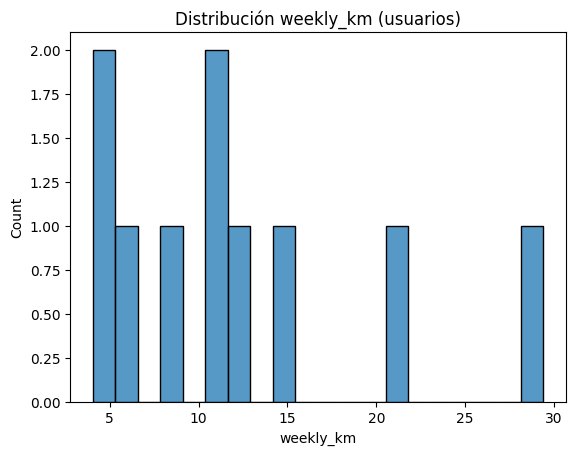

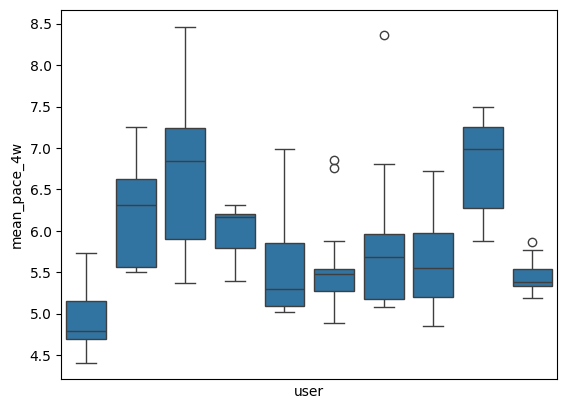

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(user_summary['weekly_km'].dropna(), bins=20)
plt.title("Distribución weekly_km (usuarios)")
plt.show()

sns.boxplot(x='user', y='mean_pace_4w', data=df_features.sample(200))
plt.xticks([], [])
plt.show()


In [13]:
# eliminar outlier mean_pace_4w > 8 min/km
df_features = df_features[df_features['mean_pace_4w'] < 8.0]

# eliminar sessions_last_7d > 7
df_features = df_features[df_features['sessions_last_7d'] < 7]

# eliminar best_5k_pace > 7 min/km
df_features = df_features[df_features['best_5k_pace'] < 7.0]

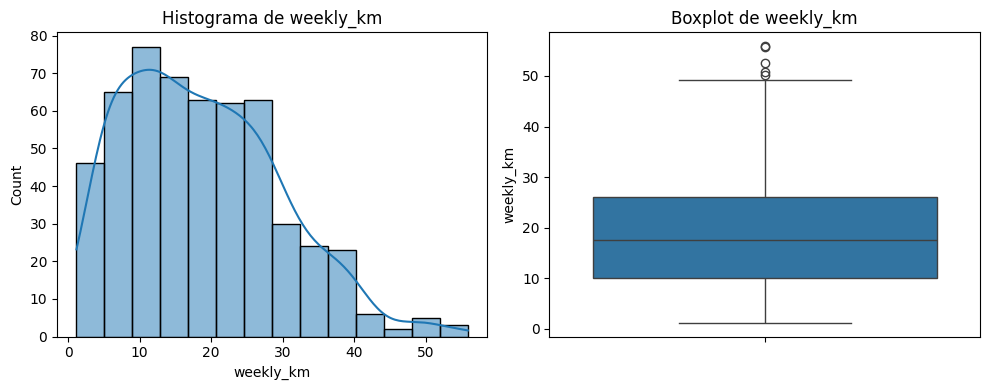

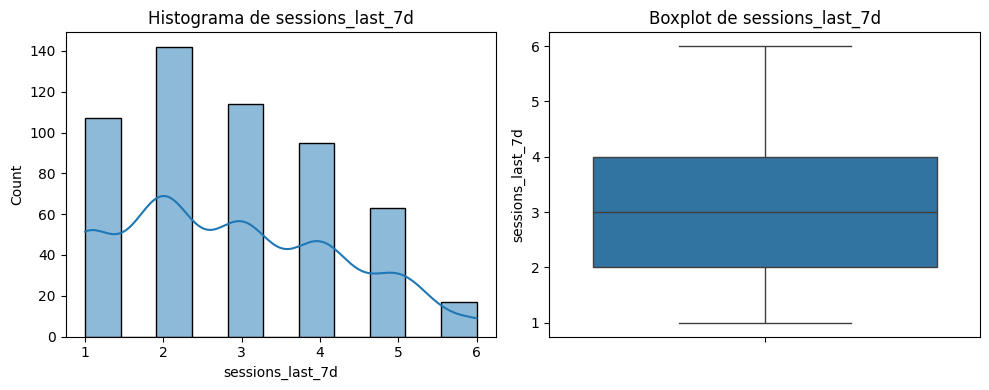

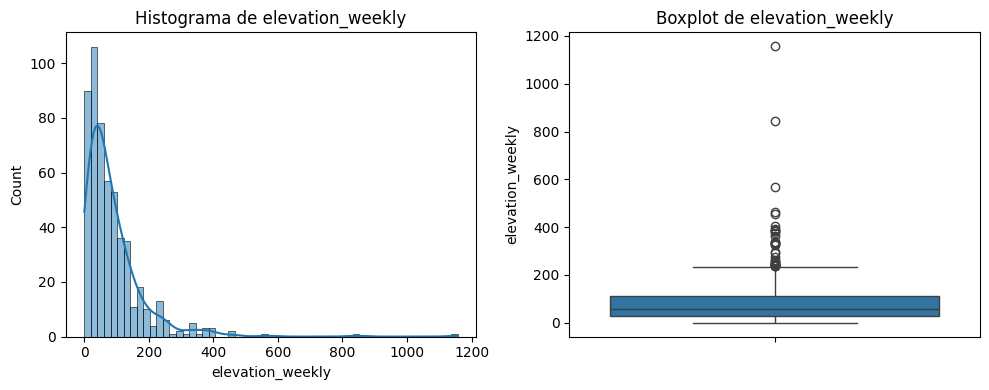

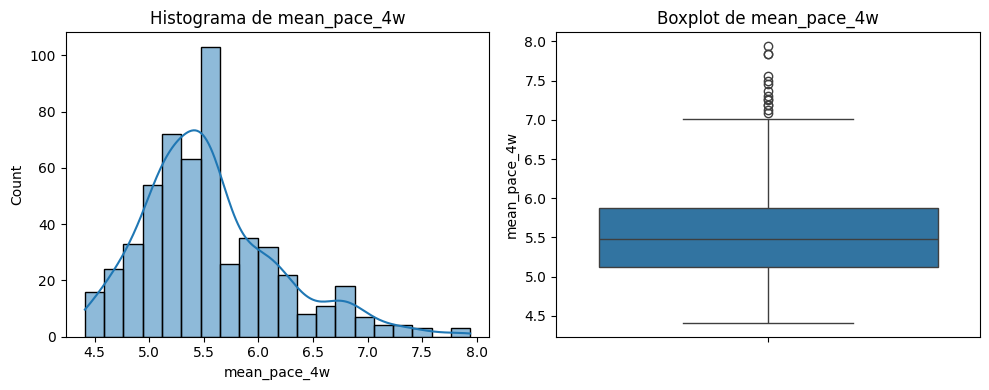

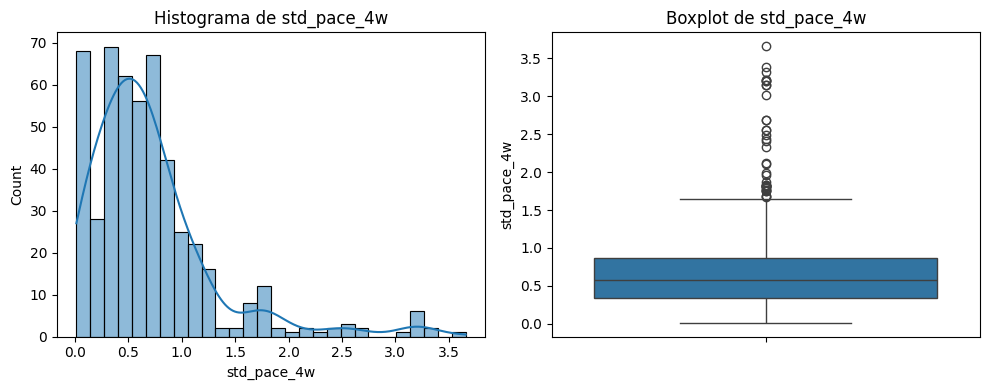

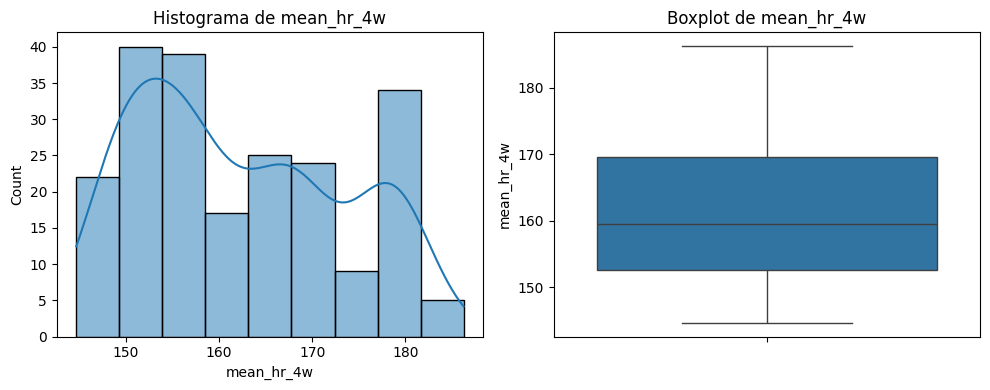

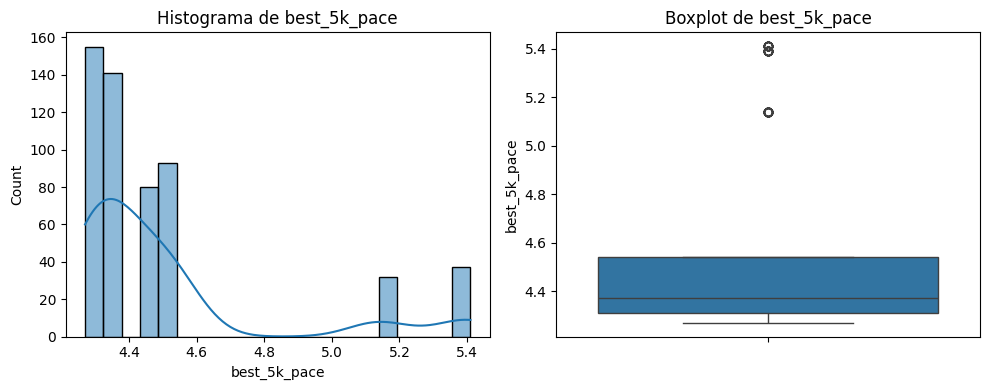

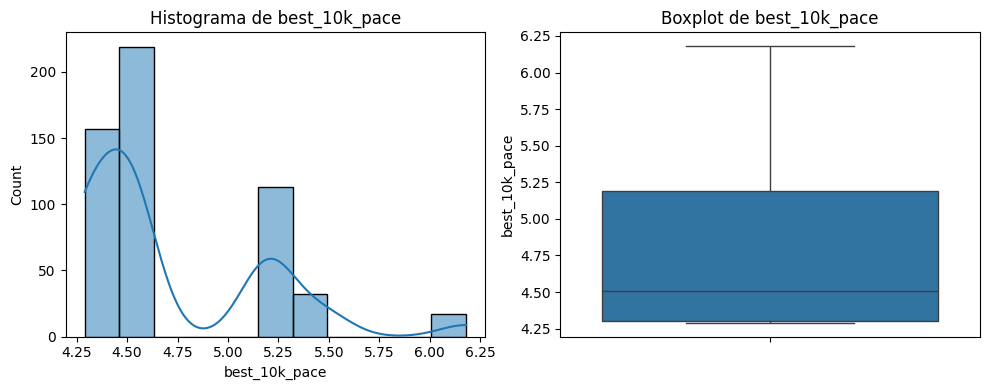

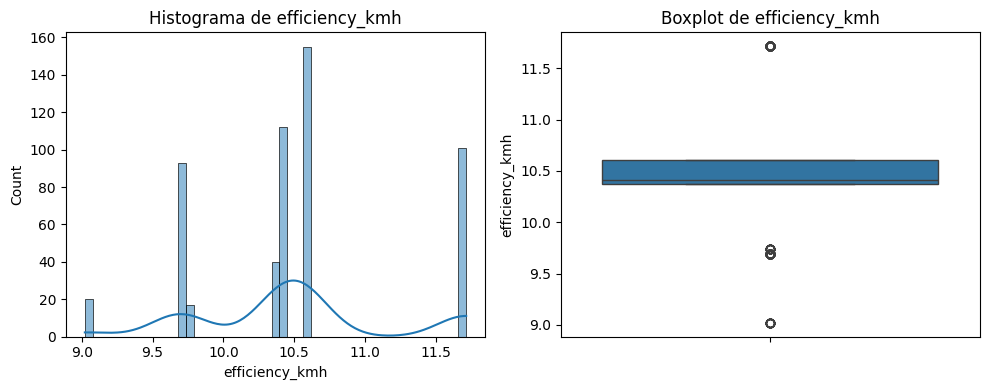

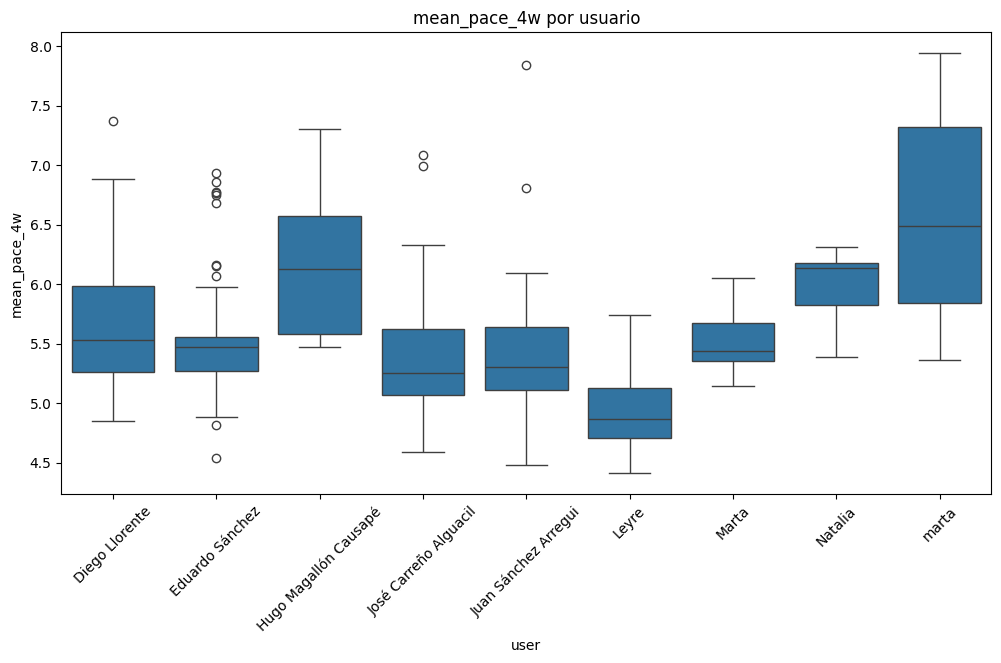

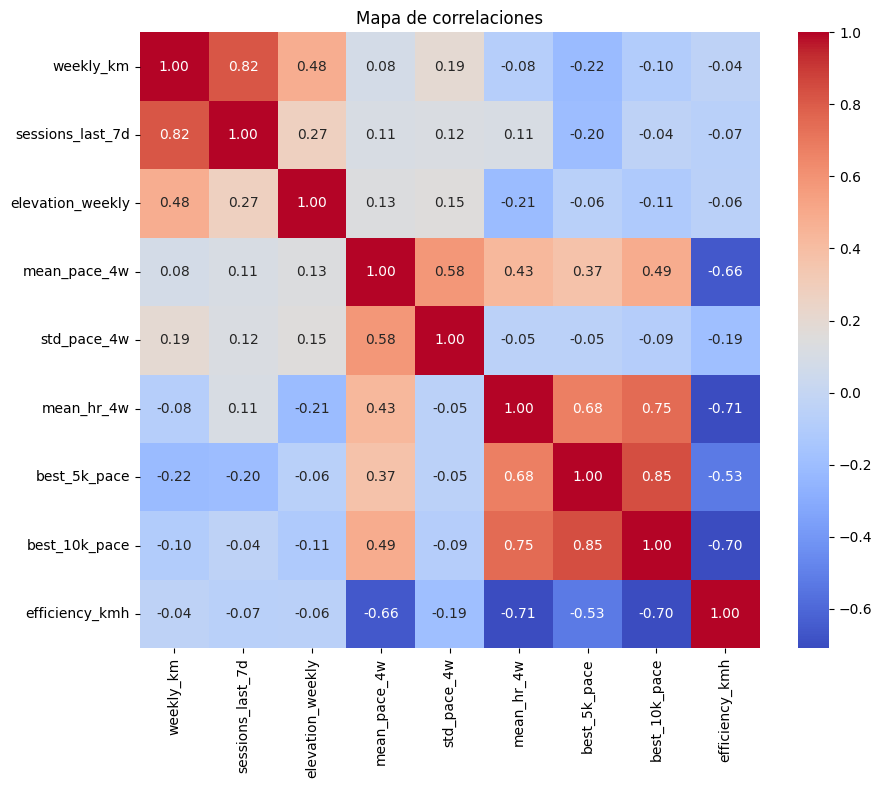

weekly_km: 5 outliers
sessions_last_7d: 0 outliers
elevation_weekly: 34 outliers
mean_pace_4w: 14 outliers
std_pace_4w: 38 outliers
mean_hr_4w: 0 outliers
best_5k_pace: 69 outliers
best_10k_pace: 0 outliers
efficiency_kmh: 231 outliers


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def EDA_visual(df):
    # Variables relevantes
    vars_continuas = [
        'weekly_km', 'sessions_last_7d', 'elevation_weekly',
        'mean_pace_4w', 'std_pace_4w', 'mean_hr_4w',
        'best_5k_pace', 'best_10k_pace', 'efficiency_kmh'
    ]
    vars_categoricas = ['user']

    # Histograma y boxplot para cada variable continua
    for var in vars_continuas:
        plt.figure(figsize=(10,4))
        plt.subplot(1,2,1)
        sns.histplot(df[var].dropna(), kde=True)
        plt.title(f'Histograma de {var}')
        plt.subplot(1,2,2)
        sns.boxplot(y=df[var].dropna())
        plt.title(f'Boxplot de {var}')
        plt.tight_layout()
        plt.show()

    # Boxplot de mean_pace_4w por usuario
    plt.figure(figsize=(12,6))
    sns.boxplot(x='user', y='mean_pace_4w', data=df)
    plt.title('mean_pace_4w por usuario')
    plt.xticks(rotation=45)
    plt.show()

    # Mapa de correlaciones
    plt.figure(figsize=(10,8))
    corr = df[vars_continuas].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Mapa de correlaciones')
    plt.show()

    for var in vars_continuas:
        q1 = df[var].quantile(0.25)
        q3 = df[var].quantile(0.75)
        iqr = q3 - q1
        outliers = df[(df[var] < q1 - 1.5*iqr) | (df[var] > q3 + 1.5*iqr)]
        print(f"{var}: {outliers.shape[0]} outliers")
    
# Ejemplo de uso:
EDA_visual(df_features)


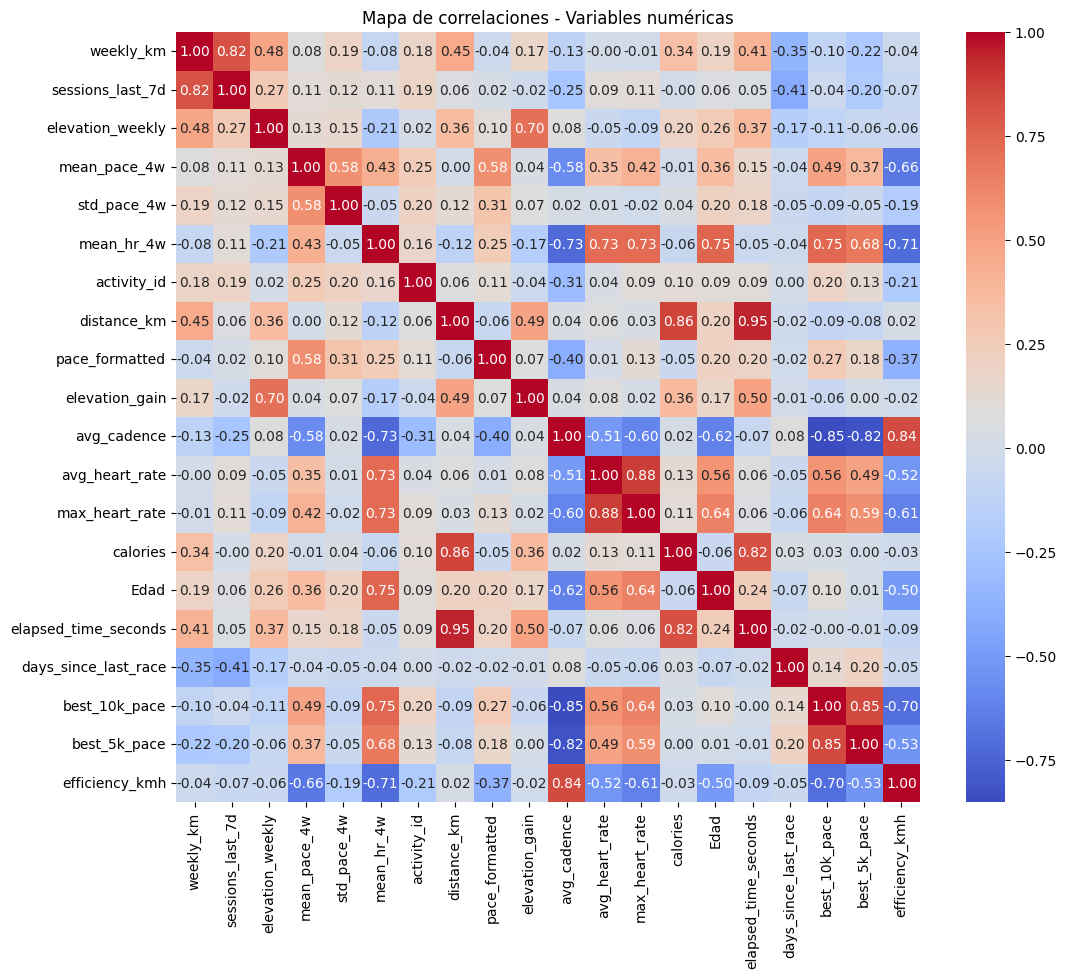

In [15]:
# mapa de correlaciones solo para variables numéricas
plt.figure(figsize=(12,10))
numeric_cols = df_features.select_dtypes(include=[np.number])
corr = numeric_cols.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Mapa de correlaciones - Variables numéricas')
plt.show()

In [17]:
# guardar el dataframe final
df_features.to_csv(r"C:\Users\eduar\OneDrive\Escritorio\Master_DataScience_AI\TFM. “Predicción del rendimiento en corredores mediante técnicas de Machine Learning un enfoque aplicado al sector deportivo”\processed\strava_features.csv", index=False)